<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/master/Google_CoLab_DL_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Libraries

In [0]:
!pip install -q tensorflow==2.0.0-beta1

In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Concatenate, GlobalMaxPooling2D, MaxPooling1D, GaussianNoise, BatchNormalization, MaxPooling2D, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
from scipy import stats
import math
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
import re

### Data

In [63]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

File ‘ml-latest-small.zip’ already there; not retrieving.



In [65]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [0]:
df = pd.read_csv ('ml-latest-small/ratings.csv')

In [0]:
df.sort_values (by='timestamp', inplace=True, ascending=True)

In [68]:
df.head(3)

,userId,movieId,rating,timestamp
66719,429,595,5.0,828124615
66716,429,588,5.0,828124615
66717,429,590,5.0,828124615


In [0]:
cutoff = int(len(df)*.90)
df['user_id'] = pd.Categorical (df['userId'])
df['user_id'] = df['user_id'].cat.codes
df['movie_id'] = pd.Categorical (df['movieId'])
df['movie_id'] = df['movie_id'].cat.codes
train, test = df.iloc[:cutoff], df.iloc[cutoff:]

In [93]:
df.head(3)

,userId,movieId,rating,timestamp,user_id,movie_id
66719,429,595,5.0,828124615,428,512
66716,429,588,5.0,828124615,428,506
66717,429,590,5.0,828124615,428,508


In [0]:
U = len(set(df['user_id']))
M = len(set(df['movie_id']))

In [0]:
K = 12 # embedding dimensions

In [0]:
user_ids = df['user_id'].values
movie_ids = df['movie_id'].values
rating = df['rating'].values

In [97]:
len(user_ids) == len(movie_ids), len(movie_ids) == len(rating)

(True, True)

In [0]:
p = np.random.permutation (len(user_ids))

In [0]:
user_ids = user_ids[p]
movie_ids = movie_ids[p]
rating = rating[p]

In [0]:
train_user = user_ids[:cutoff]
train_movie = movie_ids[:cutoff]
train_rating = rating[:cutoff]

test_user = user_ids[cutoff:]
test_movie = movie_ids[cutoff:]
test_rating = rating[cutoff:]

rating_mean = train_rating.mean()

In [0]:
train_rating = train_rating - rating_mean
test_rating = test_rating - rating_mean

In [0]:
u = Input ((1,))
m = Input ((1,))

In [0]:
u_emb = Embedding (U,K) (u) # samples, 1, K
m_emb = Embedding (M,K) (m)

In [0]:
u_emb = Flatten () (u_emb) # samples, K
m_emb = Flatten () (m_emb)

x = Concatenate () ([u_emb, m_emb])
x = Dense (400, activation='relu') (x)
x = Dropout (0.5) (x)
x = Dense (400, activation='relu') (x)
x = Dense (1, activation='relu') (x)

model = Model(inputs=[u,m], outputs=x)

In [0]:
adam = tf.keras.optimizers.Adam (learning_rate=0.005, decay=5e-6)

In [0]:
model.compile (optimizer='adam',
               loss='mse')

In [0]:
epochs = 20

r = model.fit ([train_user, train_movie], train_rating, validation_data=([test_user, test_movie], test_rating), verbose=False, epochs=epochs, batch_size=1024)

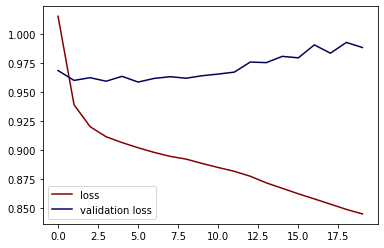

In [109]:
plt.plot (r.history['loss'], label='loss', color='#840000')
plt.plot (r.history['val_loss'], label='validation loss', color='#00035b')
plt.legend ()

In [112]:
re = model.evaluate ([test_user, test_movie], test_rating)

10084/10084 [==============================] - 1s 64us/sample - loss: 0.9882


In [114]:
re**2

0.9764865855613123

In [111]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 12)        7320        input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 12)        116688      input_6[0][0]                    
____________________________________________________________________________________________